# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Intead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12652450779370582508
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10976981812
locality {
  bus_id: 1
}
incarnation: 10936914719236585088
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0"
]


## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will intoduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [3]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [4]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [5]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [6]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    up_layer = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cc_layer = layers.concatenate([up_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    conv_1 = separable_conv2d_batchnorm(cc_layer, filters)
    output_layer = separable_conv2d_batchnorm(conv_1, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [11]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    ec_1 = encoder_block(inputs, 16, 2)
    ec_2 = encoder_block(ec_1, 16, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_1x1 = conv2d_batchnorm(ec_2, 16, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    dc_1 = decoder_block(conv_1x1, ec_1, 16)
    x = decoder_block(dc_1, inputs, 16)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [13]:
num_training_samples = 4131
num_valid_samples = 1184

learning_rate = 0.01
batch_size = 512
num_epochs = 100
steps_per_epoch = num_training_samples/batch_size
validation_steps = num_valid_samples/batch_size
workers = 4

Epoch 1/100
8/8 [============================>.] - ETA: 0s - loss: 1.1636

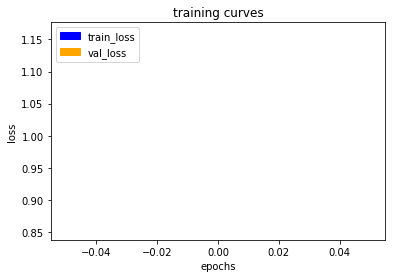

9/8 [=================================] - 28s - loss: 1.1346 - val_loss: 0.8533
Epoch 2/100
8/8 [============================>.] - ETA: 0s - loss: 0.5344

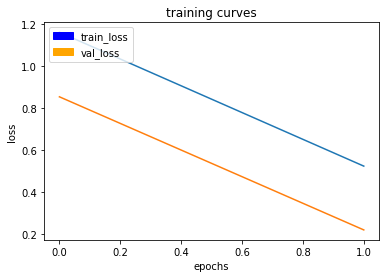

9/8 [=================================] - 20s - loss: 0.4996 - val_loss: 0.2187
Epoch 3/100
8/8 [============================>.] - ETA: 0s - loss: 0.1106

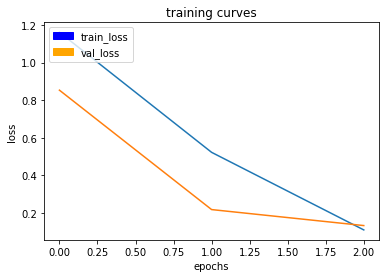

9/8 [=================================] - 20s - loss: 0.1106 - val_loss: 0.1337
Epoch 4/100
8/8 [============================>.] - ETA: 0s - loss: 0.0848

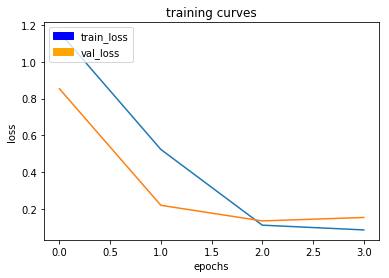

9/8 [=================================] - 23s - loss: 0.0844 - val_loss: 0.1525
Epoch 5/100
8/8 [============================>.] - ETA: 0s - loss: 0.0747

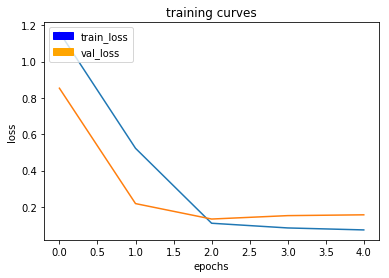

9/8 [=================================] - 20s - loss: 0.0742 - val_loss: 0.1570
Epoch 6/100
8/8 [============================>.] - ETA: 0s - loss: 0.0680

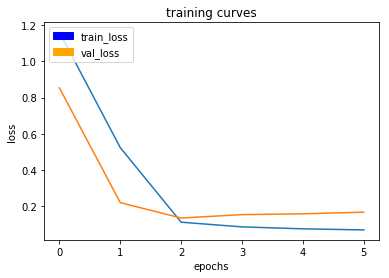

9/8 [=================================] - 19s - loss: 0.0673 - val_loss: 0.1660
Epoch 7/100
8/8 [============================>.] - ETA: 0s - loss: 0.0630

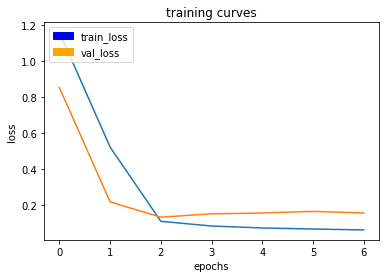

9/8 [=================================] - 19s - loss: 0.0635 - val_loss: 0.1573
Epoch 8/100
8/8 [============================>.] - ETA: 0s - loss: 0.0595

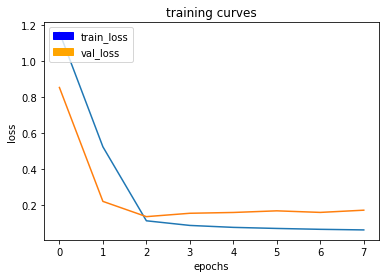

9/8 [=================================] - 19s - loss: 0.0594 - val_loss: 0.1697
Epoch 9/100
8/8 [============================>.] - ETA: 0s - loss: 0.0565

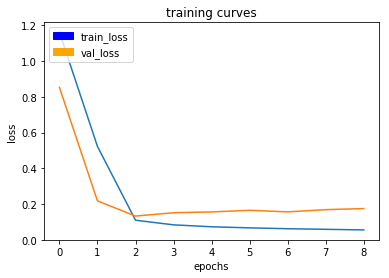

9/8 [=================================] - 19s - loss: 0.0556 - val_loss: 0.1756
Epoch 10/100
8/8 [============================>.] - ETA: 0s - loss: 0.0537

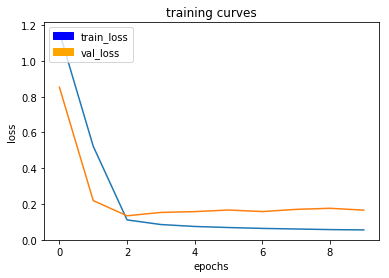

9/8 [=================================] - 21s - loss: 0.0545 - val_loss: 0.1653
Epoch 11/100
8/8 [============================>.] - ETA: 0s - loss: 0.0523

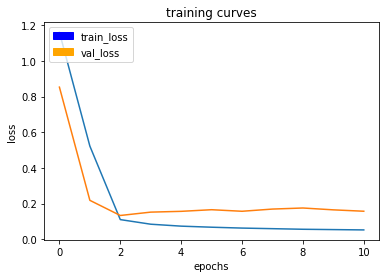

9/8 [=================================] - 20s - loss: 0.0525 - val_loss: 0.1575
Epoch 12/100
8/8 [============================>.] - ETA: 0s - loss: 0.0514

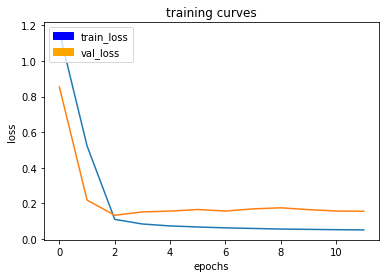

9/8 [=================================] - 19s - loss: 0.0525 - val_loss: 0.1561
Epoch 13/100
8/8 [============================>.] - ETA: 0s - loss: 0.0507

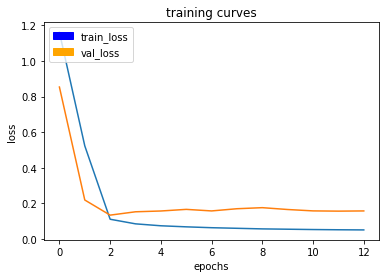

9/8 [=================================] - 21s - loss: 0.0497 - val_loss: 0.1573
Epoch 14/100
8/8 [============================>.] - ETA: 0s - loss: 0.0477

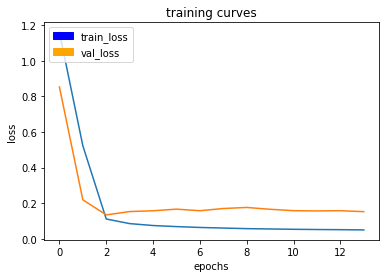

9/8 [=================================] - 19s - loss: 0.0478 - val_loss: 0.1520
Epoch 15/100
8/8 [============================>.] - ETA: 0s - loss: 0.0491

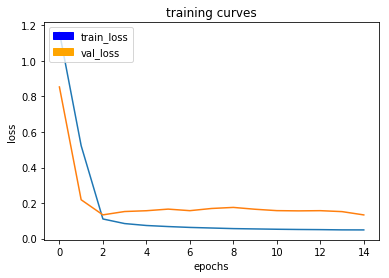

9/8 [=================================] - 23s - loss: 0.0482 - val_loss: 0.1334
Epoch 16/100
8/8 [============================>.] - ETA: 0s - loss: 0.0482

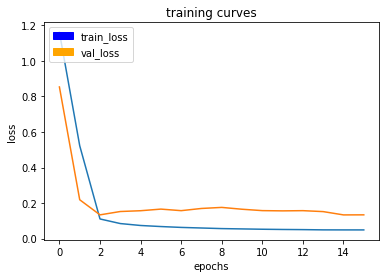

9/8 [=================================] - 21s - loss: 0.0479 - val_loss: 0.1338
Epoch 17/100
8/8 [============================>.] - ETA: 0s - loss: 0.0480

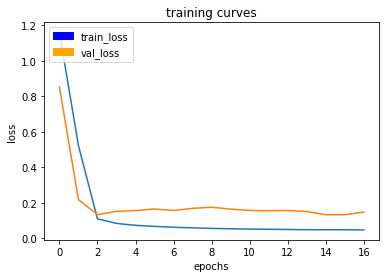

9/8 [=================================] - 18s - loss: 0.0485 - val_loss: 0.1484
Epoch 18/100
8/8 [============================>.] - ETA: 0s - loss: 0.0473

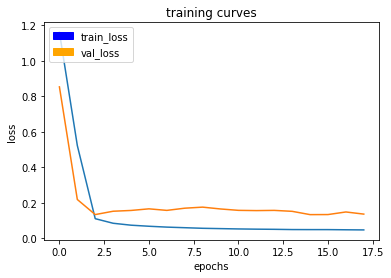

9/8 [=================================] - 19s - loss: 0.0467 - val_loss: 0.1364
Epoch 19/100
8/8 [============================>.] - ETA: 0s - loss: 0.0488

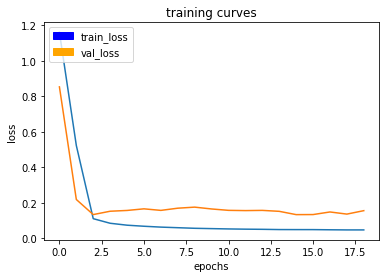

9/8 [=================================] - 18s - loss: 0.0491 - val_loss: 0.1558
Epoch 20/100
8/8 [============================>.] - ETA: 0s - loss: 0.0447

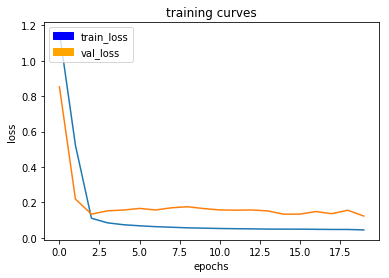

9/8 [=================================] - 22s - loss: 0.0445 - val_loss: 0.1229
Epoch 21/100
8/8 [============================>.] - ETA: 0s - loss: 0.0524

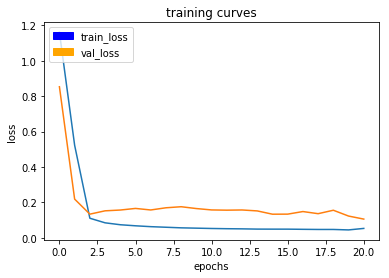

9/8 [=================================] - 21s - loss: 0.0526 - val_loss: 0.1058
Epoch 22/100
8/8 [============================>.] - ETA: 0s - loss: 0.0509

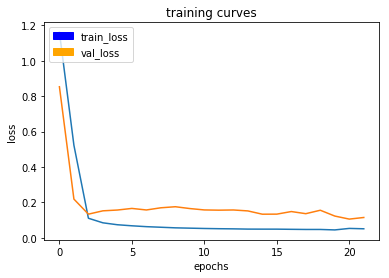

9/8 [=================================] - 21s - loss: 0.0528 - val_loss: 0.1148
Epoch 23/100
8/8 [============================>.] - ETA: 0s - loss: 0.0510

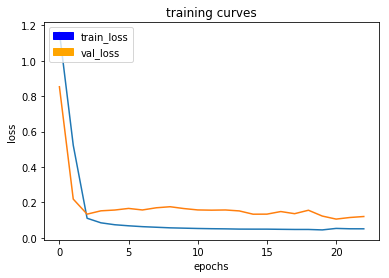

9/8 [=================================] - 23s - loss: 0.0504 - val_loss: 0.1204
Epoch 24/100
8/8 [============================>.] - ETA: 0s - loss: 0.0495

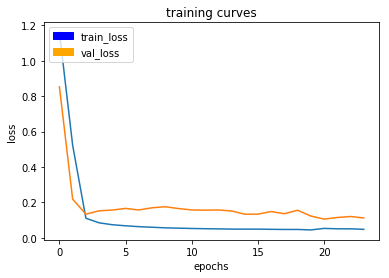

9/8 [=================================] - 18s - loss: 0.0493 - val_loss: 0.1124
Epoch 25/100
8/8 [============================>.] - ETA: 0s - loss: 0.0453

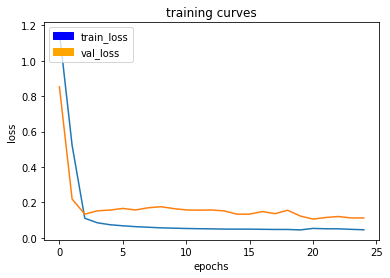

9/8 [=================================] - 18s - loss: 0.0477 - val_loss: 0.1122
Epoch 26/100
8/8 [============================>.] - ETA: 0s - loss: 0.0467

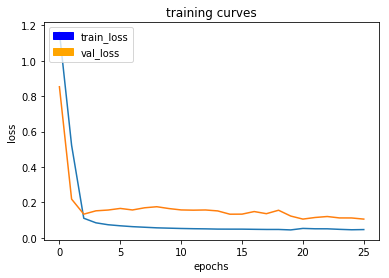

9/8 [=================================] - 22s - loss: 0.0459 - val_loss: 0.1057
Epoch 27/100
8/8 [============================>.] - ETA: 0s - loss: 0.0426

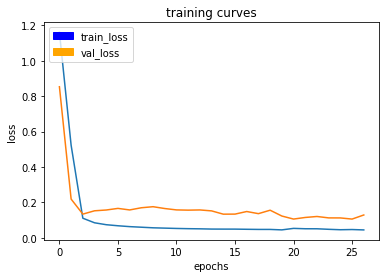

9/8 [=================================] - 19s - loss: 0.0428 - val_loss: 0.1288
Epoch 28/100
8/8 [============================>.] - ETA: 0s - loss: 0.0473

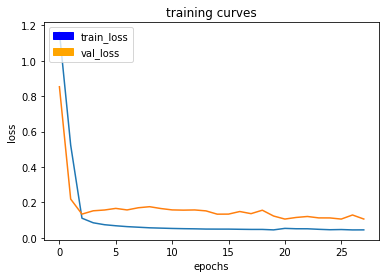

9/8 [=================================] - 19s - loss: 0.0462 - val_loss: 0.1060
Epoch 29/100
8/8 [============================>.] - ETA: 0s - loss: 0.0450

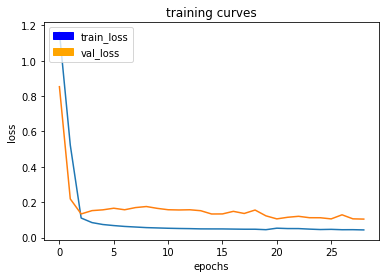

9/8 [=================================] - 21s - loss: 0.0447 - val_loss: 0.1045
Epoch 30/100
8/8 [============================>.] - ETA: 0s - loss: 0.0415

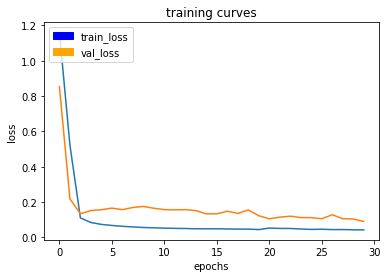

9/8 [=================================] - 19s - loss: 0.0417 - val_loss: 0.0907
Epoch 31/100
8/8 [============================>.] - ETA: 0s - loss: 0.0418

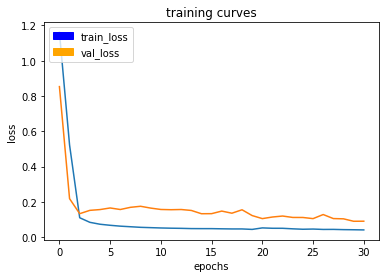

9/8 [=================================] - 19s - loss: 0.0408 - val_loss: 0.0911
Epoch 32/100
8/8 [============================>.] - ETA: 0s - loss: 0.0410

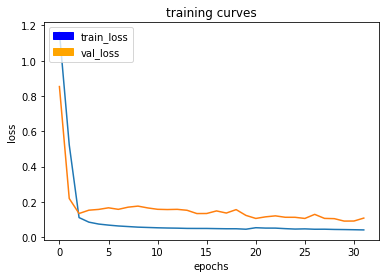

9/8 [=================================] - 19s - loss: 0.0405 - val_loss: 0.1077
Epoch 33/100
8/8 [============================>.] - ETA: 0s - loss: 0.0402

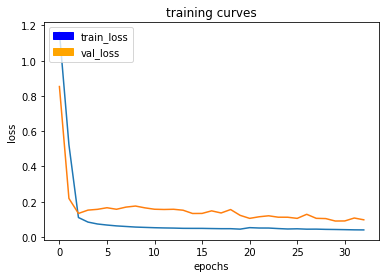

9/8 [=================================] - 23s - loss: 0.0407 - val_loss: 0.0976
Epoch 34/100
8/8 [============================>.] - ETA: 0s - loss: 0.0385

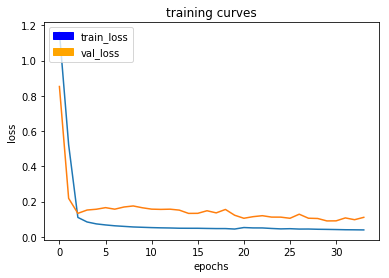

9/8 [=================================] - 21s - loss: 0.0387 - val_loss: 0.1110
Epoch 35/100
8/8 [============================>.] - ETA: 0s - loss: 0.0392

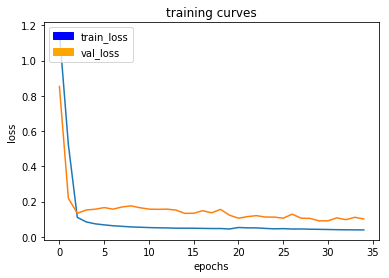

9/8 [=================================] - 19s - loss: 0.0413 - val_loss: 0.1017
Epoch 36/100
8/8 [============================>.] - ETA: 0s - loss: 0.0401

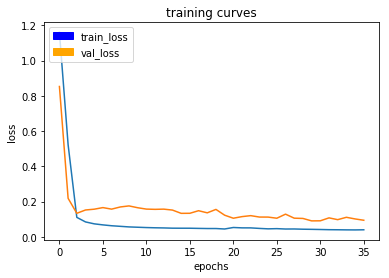

9/8 [=================================] - 23s - loss: 0.0402 - val_loss: 0.0942
Epoch 37/100
8/8 [============================>.] - ETA: 0s - loss: 0.0430

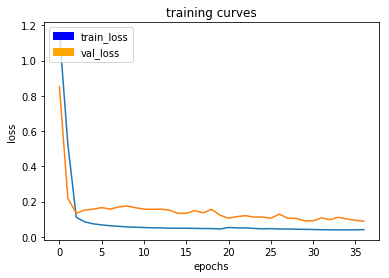

9/8 [=================================] - 17s - loss: 0.0428 - val_loss: 0.0890
Epoch 38/100
8/8 [============================>.] - ETA: 0s - loss: 0.0399

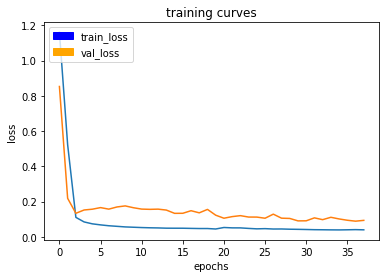

9/8 [=================================] - 19s - loss: 0.0397 - val_loss: 0.0936
Epoch 39/100
8/8 [============================>.] - ETA: 0s - loss: 0.0384

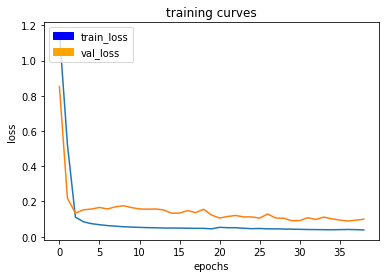

9/8 [=================================] - 22s - loss: 0.0385 - val_loss: 0.0991
Epoch 40/100
8/8 [============================>.] - ETA: 0s - loss: 0.0376

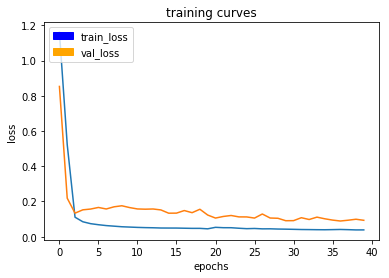

9/8 [=================================] - 21s - loss: 0.0379 - val_loss: 0.0930
Epoch 41/100
8/8 [============================>.] - ETA: 0s - loss: 0.0378

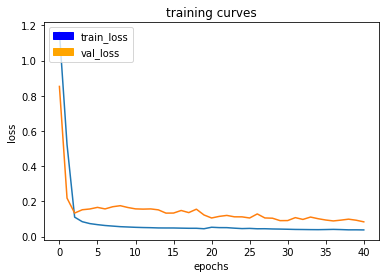

9/8 [=================================] - 20s - loss: 0.0406 - val_loss: 0.0839
Epoch 42/100
8/8 [============================>.] - ETA: 0s - loss: 0.0387

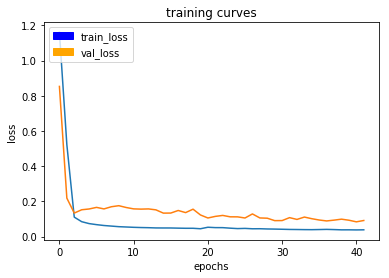

9/8 [=================================] - 23s - loss: 0.0375 - val_loss: 0.0915
Epoch 43/100
8/8 [============================>.] - ETA: 0s - loss: 0.0380

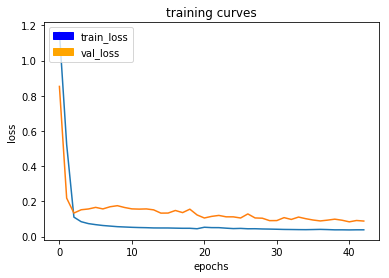

9/8 [=================================] - 20s - loss: 0.0378 - val_loss: 0.0884
Epoch 44/100
8/8 [============================>.] - ETA: 0s - loss: 0.0377

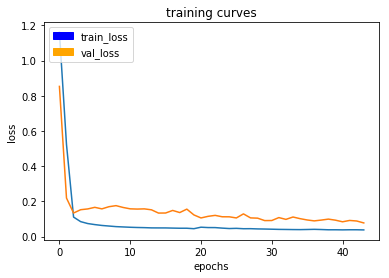

9/8 [=================================] - 19s - loss: 0.0375 - val_loss: 0.0773
Epoch 45/100
8/8 [============================>.] - ETA: 0s - loss: 0.0369

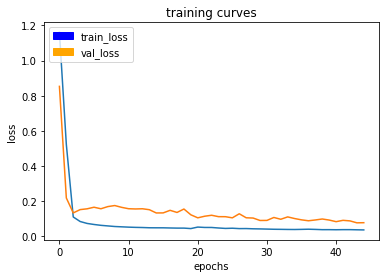

9/8 [=================================] - 23s - loss: 0.0379 - val_loss: 0.0781
Epoch 46/100
8/8 [============================>.] - ETA: 0s - loss: 0.0380

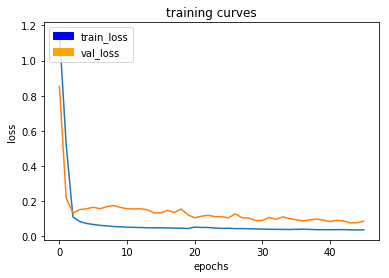

9/8 [=================================] - 20s - loss: 0.0378 - val_loss: 0.0865
Epoch 47/100
8/8 [============================>.] - ETA: 0s - loss: 0.0367

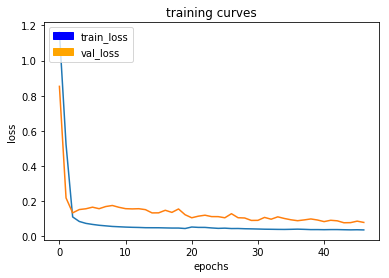

9/8 [=================================] - 19s - loss: 0.0361 - val_loss: 0.0792
Epoch 48/100
8/8 [============================>.] - ETA: 0s - loss: 0.0366

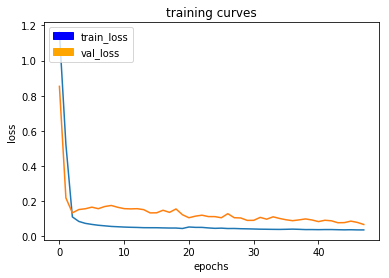

9/8 [=================================] - 20s - loss: 0.0356 - val_loss: 0.0674
Epoch 49/100
8/8 [============================>.] - ETA: 0s - loss: 0.0369

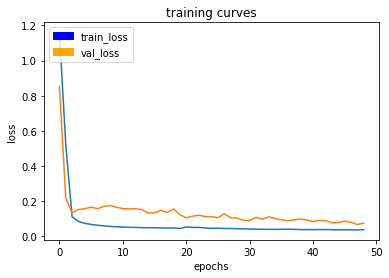

9/8 [=================================] - 19s - loss: 0.0373 - val_loss: 0.0752
Epoch 50/100
8/8 [============================>.] - ETA: 0s - loss: 0.0356

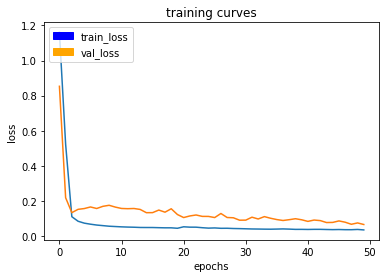

9/8 [=================================] - 22s - loss: 0.0354 - val_loss: 0.0662
Epoch 51/100
8/8 [============================>.] - ETA: 0s - loss: 0.0359

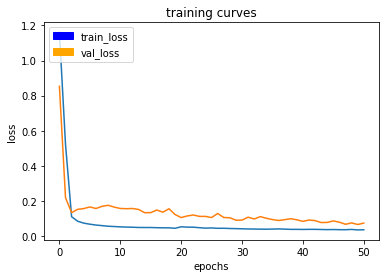

9/8 [=================================] - 18s - loss: 0.0356 - val_loss: 0.0742
Epoch 52/100
8/8 [============================>.] - ETA: 0s - loss: 0.0356

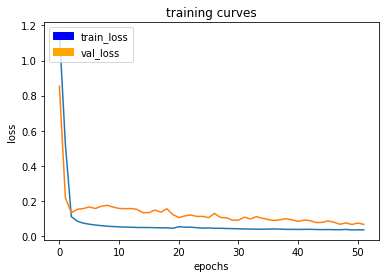

9/8 [=================================] - 22s - loss: 0.0359 - val_loss: 0.0669
Epoch 53/100
8/8 [============================>.] - ETA: 0s - loss: 0.0359

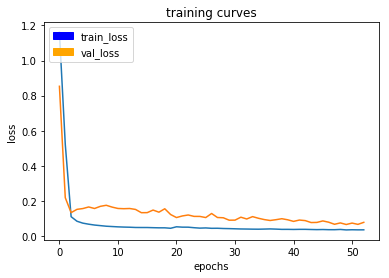

9/8 [=================================] - 20s - loss: 0.0353 - val_loss: 0.0785
Epoch 54/100
8/8 [============================>.] - ETA: 0s - loss: 0.0361

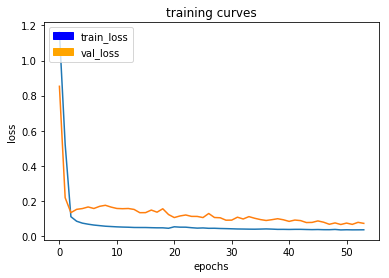

9/8 [=================================] - 21s - loss: 0.0354 - val_loss: 0.0726
Epoch 55/100
8/8 [============================>.] - ETA: 0s - loss: 0.0370

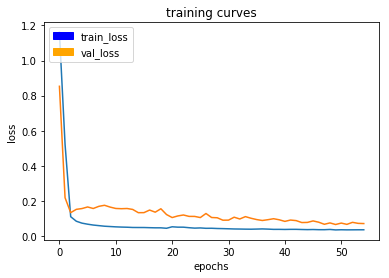

9/8 [=================================] - 21s - loss: 0.0365 - val_loss: 0.0715
Epoch 56/100
8/8 [============================>.] - ETA: 0s - loss: 0.0352

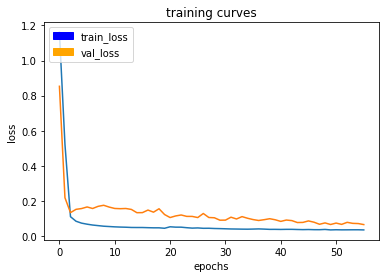

9/8 [=================================] - 21s - loss: 0.0364 - val_loss: 0.0657
Epoch 57/100
8/8 [============================>.] - ETA: 0s - loss: 0.0519

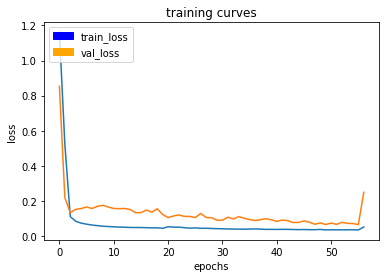

9/8 [=================================] - 20s - loss: 0.0521 - val_loss: 0.2494
Epoch 58/100
8/8 [============================>.] - ETA: 0s - loss: 0.0484

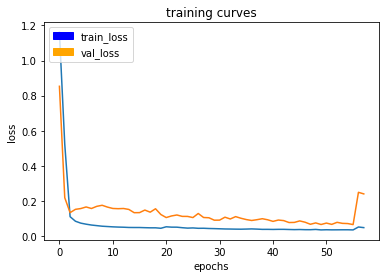

9/8 [=================================] - 22s - loss: 0.0473 - val_loss: 0.2404
Epoch 59/100
8/8 [============================>.] - ETA: 0s - loss: 0.0431

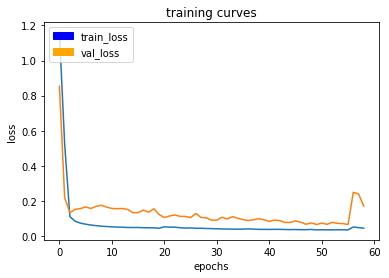

9/8 [=================================] - 21s - loss: 0.0440 - val_loss: 0.1706
Epoch 60/100
8/8 [============================>.] - ETA: 0s - loss: 0.0430

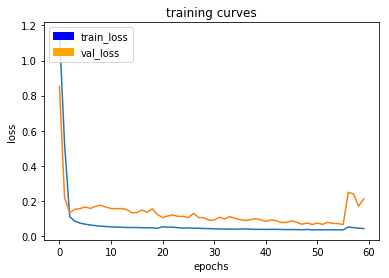

9/8 [=================================] - 19s - loss: 0.0424 - val_loss: 0.2123
Epoch 61/100
8/8 [============================>.] - ETA: 0s - loss: 0.0404

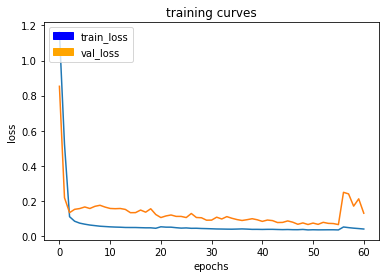

9/8 [=================================] - 23s - loss: 0.0395 - val_loss: 0.1304
Epoch 62/100
8/8 [============================>.] - ETA: 0s - loss: 0.0387

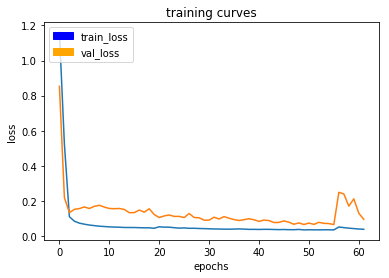

9/8 [=================================] - 21s - loss: 0.0385 - val_loss: 0.0957
Epoch 63/100
8/8 [============================>.] - ETA: 0s - loss: 0.0373

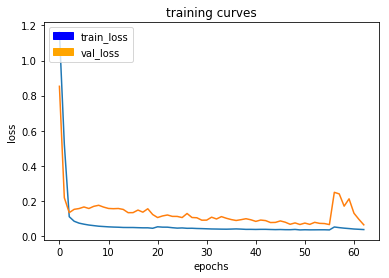

9/8 [=================================] - 19s - loss: 0.0370 - val_loss: 0.0642
Epoch 64/100
8/8 [============================>.] - ETA: 0s - loss: 0.0366

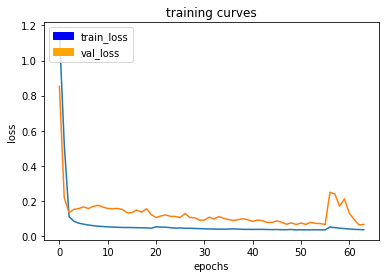

9/8 [=================================] - 24s - loss: 0.0365 - val_loss: 0.0667
Epoch 65/100
8/8 [============================>.] - ETA: 0s - loss: 0.0361

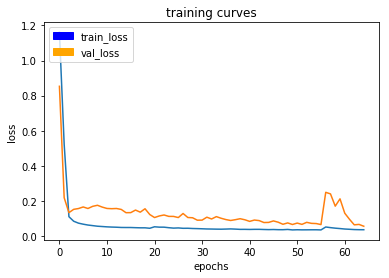

9/8 [=================================] - 20s - loss: 0.0358 - val_loss: 0.0562
Epoch 66/100
8/8 [============================>.] - ETA: 0s - loss: 0.0360

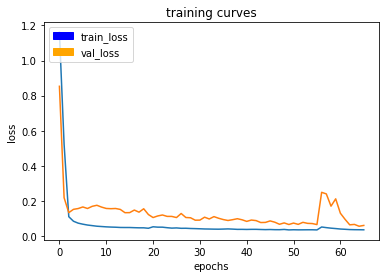

9/8 [=================================] - 19s - loss: 0.0351 - val_loss: 0.0609
Epoch 67/100
8/8 [============================>.] - ETA: 0s - loss: 0.0357

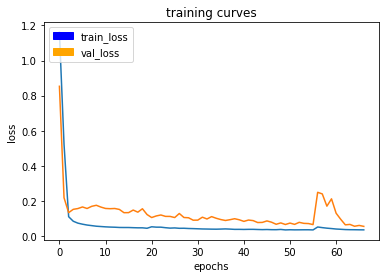

9/8 [=================================] - 20s - loss: 0.0347 - val_loss: 0.0554
Epoch 68/100
8/8 [============================>.] - ETA: 0s - loss: 0.0383

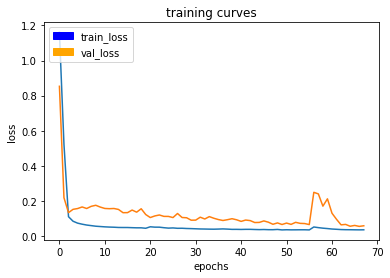

9/8 [=================================] - 22s - loss: 0.0380 - val_loss: 0.0588
Epoch 69/100
8/8 [============================>.] - ETA: 0s - loss: 0.0371

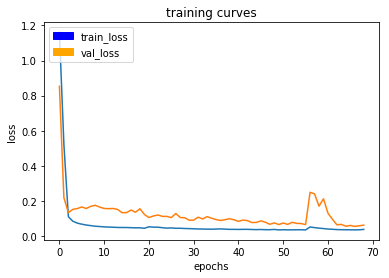

9/8 [=================================] - 20s - loss: 0.0378 - val_loss: 0.0625
Epoch 70/100
8/8 [============================>.] - ETA: 0s - loss: 0.0369

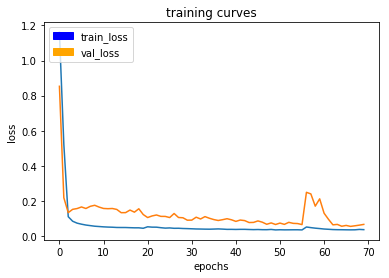

9/8 [=================================] - 23s - loss: 0.0361 - val_loss: 0.0667
Epoch 71/100
8/8 [============================>.] - ETA: 0s - loss: 0.0384

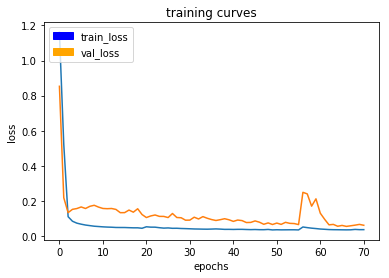

9/8 [=================================] - 21s - loss: 0.0379 - val_loss: 0.0617
Epoch 72/100
8/8 [============================>.] - ETA: 0s - loss: 0.0368

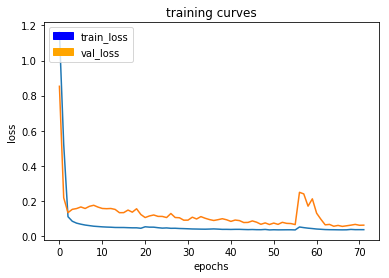

9/8 [=================================] - 20s - loss: 0.0361 - val_loss: 0.0624
Epoch 73/100
8/8 [============================>.] - ETA: 0s - loss: 0.0354

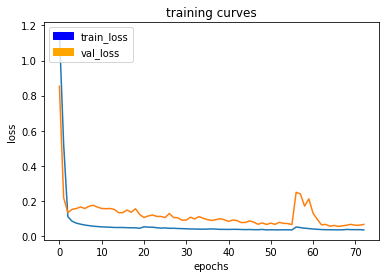

9/8 [=================================] - 21s - loss: 0.0351 - val_loss: 0.0665
Epoch 74/100
8/8 [============================>.] - ETA: 0s - loss: 0.0341

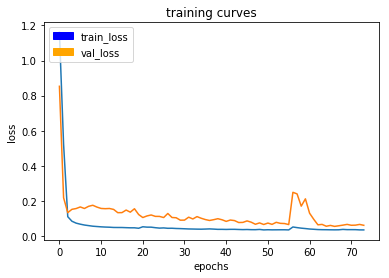

9/8 [=================================] - 20s - loss: 0.0345 - val_loss: 0.0615
Epoch 75/100
8/8 [============================>.] - ETA: 0s - loss: 0.0347

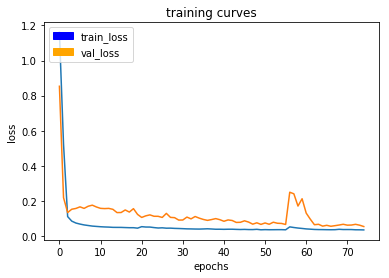

9/8 [=================================] - 18s - loss: 0.0338 - val_loss: 0.0539
Epoch 76/100
8/8 [============================>.] - ETA: 0s - loss: 0.0348

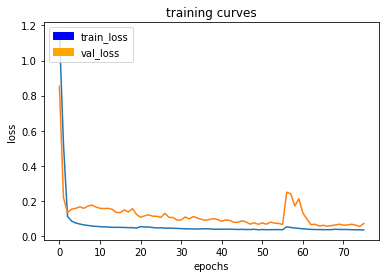

9/8 [=================================] - 20s - loss: 0.0341 - val_loss: 0.0711
Epoch 77/100
8/8 [============================>.] - ETA: 0s - loss: 0.0338

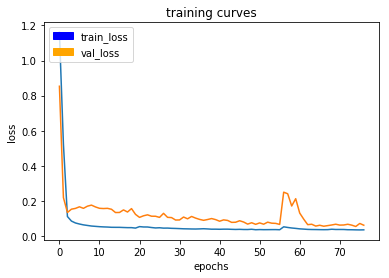

9/8 [=================================] - 19s - loss: 0.0342 - val_loss: 0.0611
Epoch 78/100
8/8 [============================>.] - ETA: 0s - loss: 0.0341

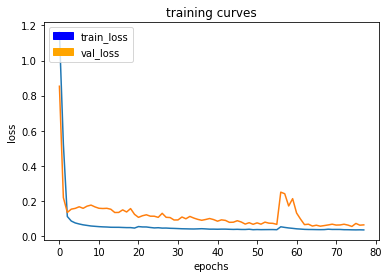

9/8 [=================================] - 20s - loss: 0.0344 - val_loss: 0.0629
Epoch 79/100
8/8 [============================>.] - ETA: 0s - loss: 0.0333

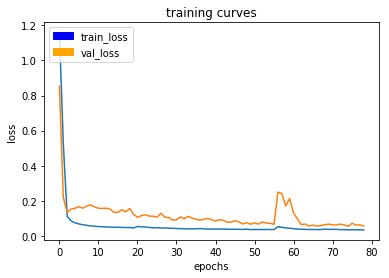

9/8 [=================================] - 19s - loss: 0.0334 - val_loss: 0.0551
Epoch 80/100
8/8 [============================>.] - ETA: 0s - loss: 0.0344

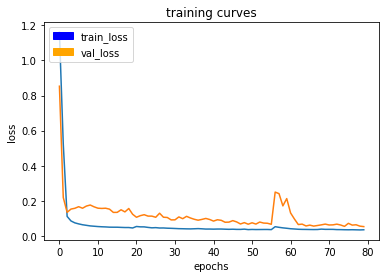

9/8 [=================================] - 20s - loss: 0.0336 - val_loss: 0.0524
Epoch 81/100
8/8 [============================>.] - ETA: 0s - loss: 0.0331

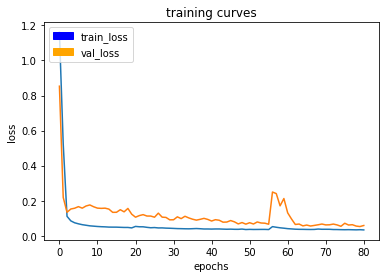

9/8 [=================================] - 21s - loss: 0.0328 - val_loss: 0.0584
Epoch 82/100
8/8 [============================>.] - ETA: 0s - loss: 0.0337

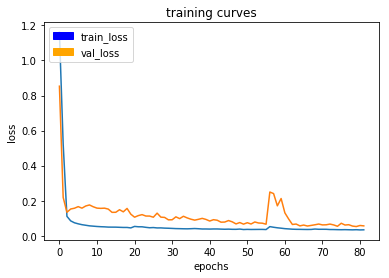

9/8 [=================================] - 21s - loss: 0.0335 - val_loss: 0.0562
Epoch 83/100
8/8 [============================>.] - ETA: 0s - loss: 0.0346

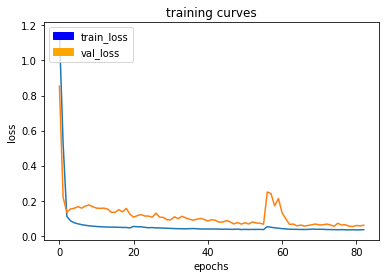

9/8 [=================================] - 23s - loss: 0.0347 - val_loss: 0.0601
Epoch 84/100
8/8 [============================>.] - ETA: 0s - loss: 0.0329

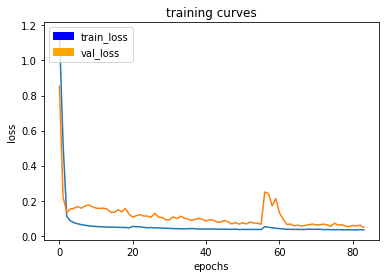

9/8 [=================================] - 18s - loss: 0.0330 - val_loss: 0.0471
Epoch 85/100
8/8 [============================>.] - ETA: 0s - loss: 0.0329

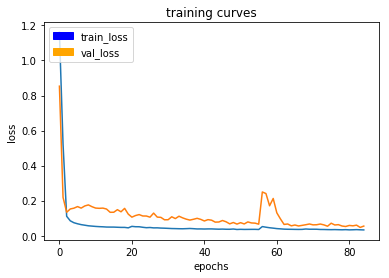

9/8 [=================================] - 18s - loss: 0.0325 - val_loss: 0.0547
Epoch 86/100
8/8 [============================>.] - ETA: 0s - loss: 0.0332

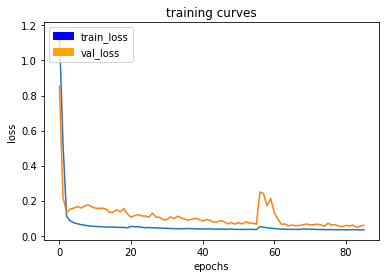

9/8 [=================================] - 18s - loss: 0.0356 - val_loss: 0.0592
Epoch 87/100
8/8 [============================>.] - ETA: 0s - loss: 0.0351

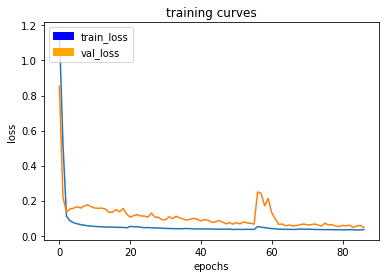

9/8 [=================================] - 20s - loss: 0.0347 - val_loss: 0.0467
Epoch 88/100
8/8 [============================>.] - ETA: 0s - loss: 0.0324

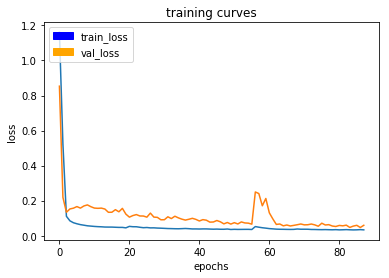

9/8 [=================================] - 21s - loss: 0.0329 - val_loss: 0.0592
Epoch 89/100
8/8 [============================>.] - ETA: 0s - loss: 0.0330

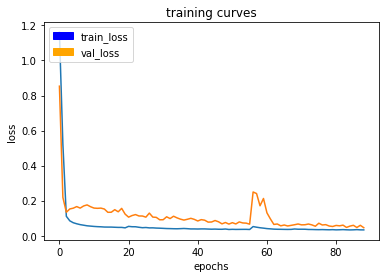

9/8 [=================================] - 20s - loss: 0.0325 - val_loss: 0.0455
Epoch 90/100
8/8 [============================>.] - ETA: 0s - loss: 0.0335

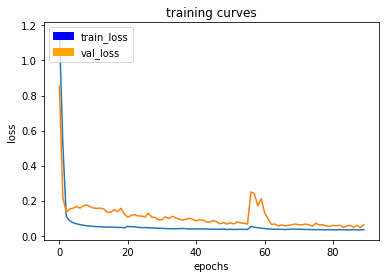

9/8 [=================================] - 24s - loss: 0.0336 - val_loss: 0.0630
Epoch 91/100
8/8 [============================>.] - ETA: 0s - loss: 0.0320

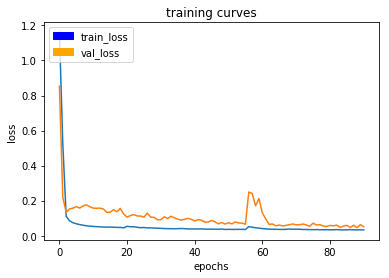

9/8 [=================================] - 21s - loss: 0.0325 - val_loss: 0.0509
Epoch 92/100
8/8 [============================>.] - ETA: 0s - loss: 0.0325

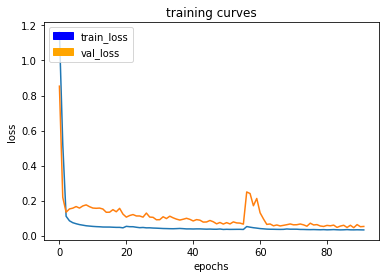

9/8 [=================================] - 20s - loss: 0.0350 - val_loss: 0.0524
Epoch 93/100
8/8 [============================>.] - ETA: 0s - loss: 0.0332

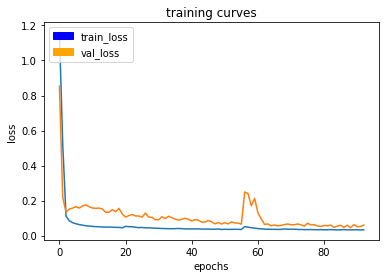

9/8 [=================================] - 20s - loss: 0.0334 - val_loss: 0.0606
Epoch 94/100
8/8 [============================>.] - ETA: 0s - loss: 0.0326

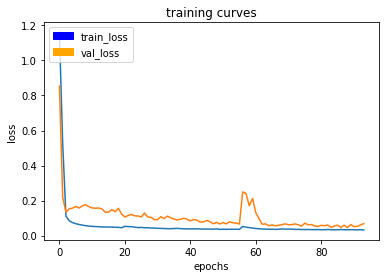

9/8 [=================================] - 20s - loss: 0.0325 - val_loss: 0.0685
Epoch 95/100
8/8 [============================>.] - ETA: 0s - loss: 0.0336

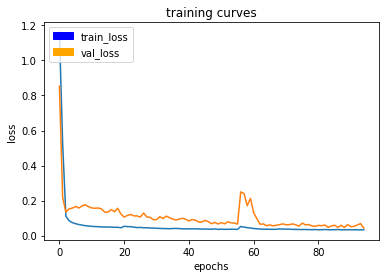

9/8 [=================================] - 20s - loss: 0.0332 - val_loss: 0.0428
Epoch 96/100
8/8 [============================>.] - ETA: 0s - loss: 0.0326

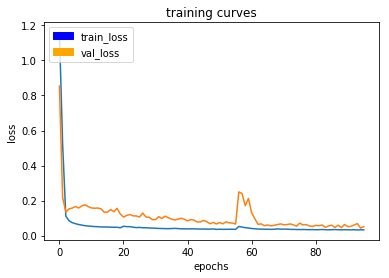

9/8 [=================================] - 18s - loss: 0.0321 - val_loss: 0.0510
Epoch 97/100
8/8 [============================>.] - ETA: 0s - loss: 0.0320

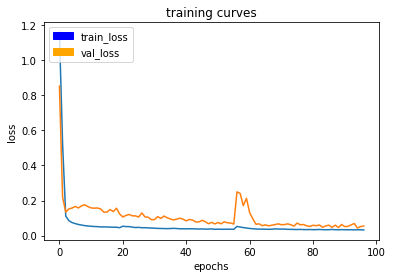

9/8 [=================================] - 21s - loss: 0.0314 - val_loss: 0.0543
Epoch 98/100
8/8 [============================>.] - ETA: 0s - loss: 0.0315

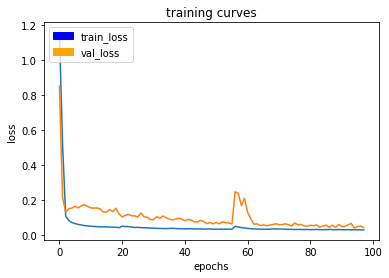

9/8 [=================================] - 20s - loss: 0.0312 - val_loss: 0.0452
Epoch 99/100
8/8 [============================>.] - ETA: 0s - loss: 0.0320

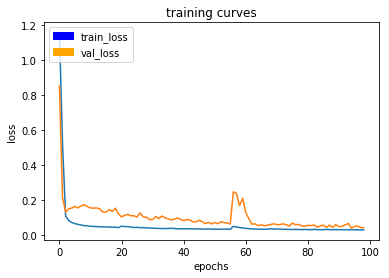

9/8 [=================================] - 18s - loss: 0.0312 - val_loss: 0.0448
Epoch 100/100
8/8 [============================>.] - ETA: 0s - loss: 0.0319

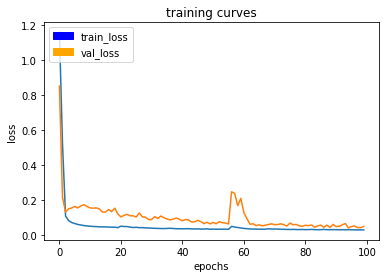

9/8 [=================================] - 19s - loss: 0.0314 - val_loss: 0.0514


In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [15]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [16]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [17]:
# generate predictions, save in the runs, directory.
run_number = 'run1'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

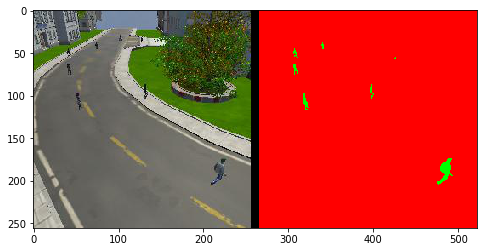

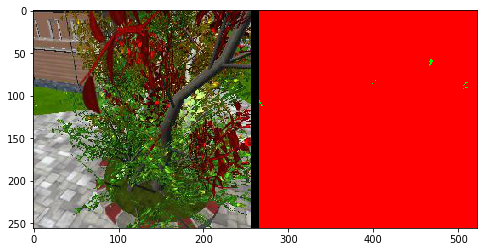

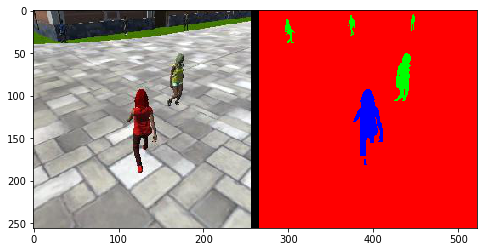

In [20]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [19]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9892762878497183
average intersection over union for other people is 0.26400117036178494
average intersection over union for hero is 0.09842189445443303
global average intersection over union is 0.4505664508886455
